# Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
import ipaddress


# Load the Datasets

In [2]:
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
credit_df = pd.read_csv('../data/creditcard.csv')
ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')


# Handle Missing Values

In [3]:
# Check for missing values
fraud_df.isnull().sum()

# Example: Drop rows with missing target or critical features
fraud_df.dropna(subset=['class'], inplace=True)

# Impute missing categorical data
fraud_df['browser'].fillna(fraud_df['browser'].mode()[0], inplace=True)


C:\Users\addis\AppData\Local\Temp\ipykernel_5032\1578621130.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_df['browser'].fillna(fraud_df['browser'].mode()[0], inplace=True)


# Data Cleaning

In [4]:
# Remove duplicates
fraud_df.drop_duplicates(inplace=True)

# Convert datetime columns
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])


# Exploratory Data Analysis (EDA)

<Axes: title={'center': 'Fraudulent vs Non-Fraudulent Transactions'}, xlabel='class', ylabel='count'>

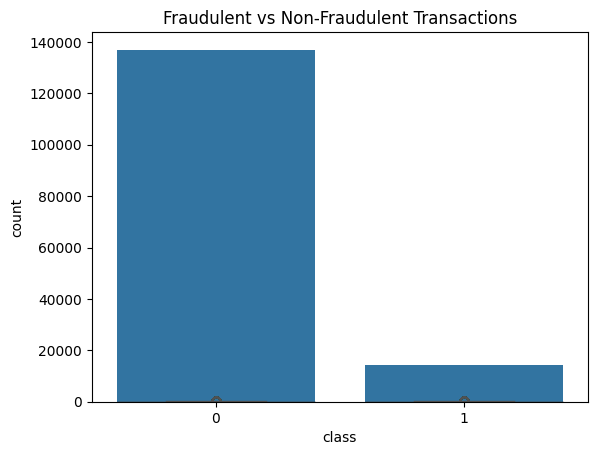

In [5]:
#Univariate
sns.countplot(x='class', data=fraud_df)
plt.title('Fraudulent vs Non-Fraudulent Transactions')


#Bivariate
sns.boxplot(x='class', y='purchase_value', data=fraud_df)


# Merge Datasets for Geolocation

In [8]:
# Convert IP to integer

def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

fraud_df['ip_address_int'] = fraud_df['ip_address'].astype('int')
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype('int')
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype('int')

# Merge with IP Ranges
def find_country(ip, ip_ranges):
    row = ip_ranges[(ip_ranges['lower_bound_ip_address'] <= ip) & 
                    (ip_ranges['upper_bound_ip_address'] >= ip)]
    return row['country'].values[0] if not row.empty else 'Unknown'

fraud_df['country'] = fraud_df['ip_address_int'].apply(lambda ip: find_country(ip, ip_df))




# Feature Engineering

In [9]:
# Time-based Features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

# Transaction Frequency / Velocity (Basic)
user_txn_count = fraud_df.groupby('user_id').size().rename('user_transaction_count')
fraud_df = fraud_df.merge(user_txn_count, on='user_id')


# Handle Class Imbalance

In [10]:
# Check imbalance
fraud_df['class'].value_counts(normalize=True)

# Apply Sampling
X = fraud_df.drop(columns=['class'])
y = fraud_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train.select_dtypes(include=[np.number]), y_train)


#  Normalization and Scaling

In [11]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)


# Encode Categorical Features

In [12]:
X_encoded = pd.get_dummies(X_train[['source', 'browser', 'sex']], drop_first=True)

X_train_final = pd.concat([X_train.select_dtypes(include=[np.number]).reset_index(drop=True),
                           X_encoded.reset_index(drop=True)], axis=1)


# Output Processed Data

In [13]:
X_train_final.to_csv('../outputs/processed_data/X_train.csv', index=False)
y_train.to_csv('../outputs/processed_data/y_train.csv', index=False)
